## Libraries

In [1]:
import pandas as pd
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split

c:\Users\ADMIN\anaconda3\envs\ds-gg\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from src.load_data import load_data

file_path='../data/raw/housing_data.csv'

df = load_data(file_path)

# Select specified columns for app
selected_columns = [ 
    'Latitude',
    'SqFtTotLiving',
    'SqFt2ndFloor',
    'Longitude',
    'YrBuilt',
    'SqFtFinBasement',
    'SqFt1stFloor',
    'SalePrice'
]

# Filter the DataFrame to include only the selected columns
df = df[selected_columns]
df.head()

,Latitude,SqFtTotLiving,SqFt2ndFloor,Longitude,YrBuilt,SqFtFinBasement,SqFt1stFloor,SalePrice
0,47.336118,3180,0,-122.196399,1965,1590,1590,400000
1,47.509874,2200,0,-122.361913,1945,810,1390,474250
2,47.437557,2525,1515,-122.156684,2019,0,1010,667950
3,47.565146,1820,540,-122.370252,2016,620,660,659000
4,47.730389,2310,0,-122.184194,1967,0,2310,656500


In [3]:
#define target
y=df['SalePrice']
X=df.drop(columns='SalePrice')

In [6]:
# save x new dataset for the app
new_dataset = X.to_csv('../data/transformed/new_housing_df.csv', index=False)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing and Pipeline

In [10]:
from src.preprocessor import create_preprocessing_pipeline

preprocessor = create_preprocessing_pipeline()

In [11]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [12]:
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

print("Columns after transformation:", preprocessor.get_feature_names_out())


Columns after transformation: ['numeric__Latitude' 'numeric__SqFtTotLiving' 'numeric__SqFt2ndFloor'
 'numeric__Longitude' 'numeric__YrBuilt' 'numeric__SqFtFinBasement'
 'numeric__SqFt1stFloor']


## Machine Learning 

In [13]:
from lightgbm import LGBMRegressor
from src.train_predict import train_and_predict_model

lgbm_model = LGBMRegressor()

# Extracting the model from the returned tuple
trained_lgbm_model = train_and_predict_model(X_train_transformed_df, y_train, X_test_transformed_df, preprocessor, lgbm_model)


Training set metrics:
MAE: 68812.5045645303
MSE: 10155354997.309095
R²: 0.8858786977334615

Testing set metrics:
MAE: 96208.94650789749
MSE: 20293730938.83371
R²: 0.767696673830146


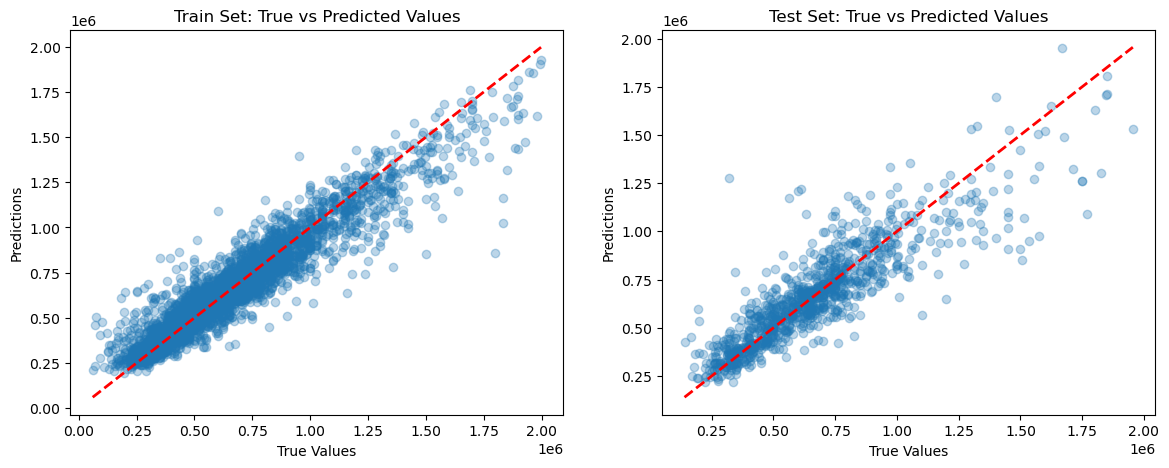

Model Saved to ../models/lgbm_model.joblib


In [17]:
from src.evaluate_model import evaluate_regression_model, save_model

evaluate_regression_model(trained_lgbm_model, X_train_transformed_df, y_train, X_test_transformed_df, y_test)

#save the trained model to the models folder
model_path = '../models/lgbm_model.joblib'
save_model(lgbm_model, model_path)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor()

# Train the model on the preprocessed data and predict the target variable for the test set
trained_gbr_model = train_and_predict_model(X_train_transformed_df, y_train, X_test_transformed_df, preprocessor, gbr_model)

Training set metrics:
MAE: 96333.26680524397
MSE: 20676528592.183727
R²: 0.7676464909482172

Testing set metrics:
MAE: 107516.13135631468
MSE: 25852590238.165543
R²: 0.7040641407667494


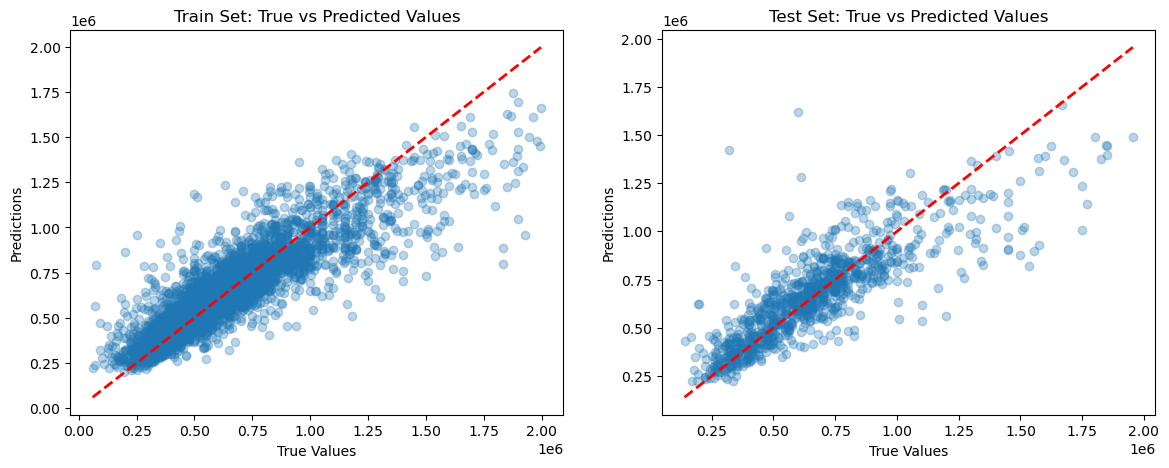

Model Saved to ../models/gbr_model.joblib


In [19]:
evaluate_regression_model(trained_gbr_model, X_train_transformed_df, y_train, X_test_transformed_df, y_test)

#save the trained model to the models folder
model_path = '../models/gbr_model.joblib'
save_model(gbr_model, model_path)

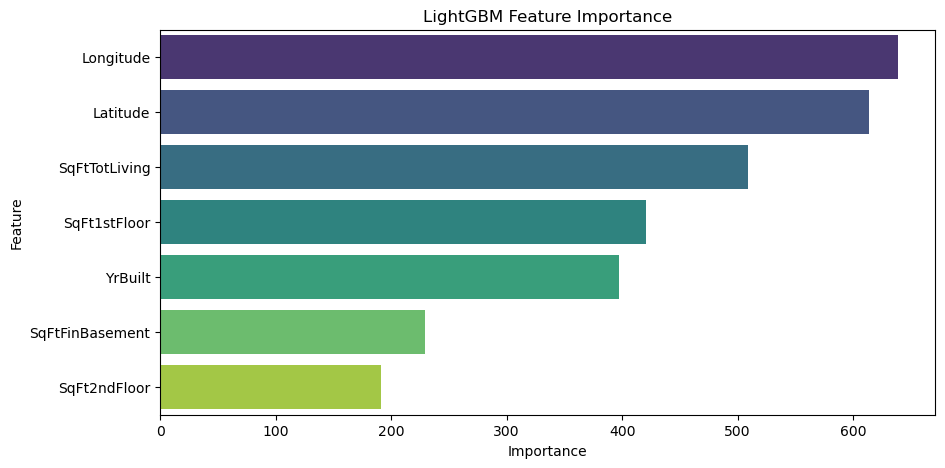

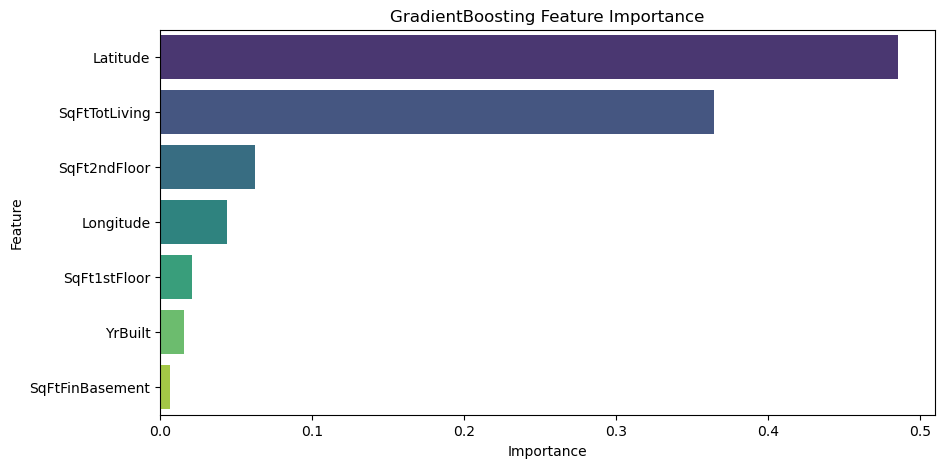

In [20]:
from src.feature_importance import train_model, get_feature_importance, plot_feature_importance
# Get feature names
feature_names = X_train.columns
# Train LGBM model
trained_lgbm_model = train_model(lgbm_model, X_train, y_train)
# Get and plot the feature importance of the trained LGBM model
lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
plot_feature_importance(lgbm_feature_importance, 'LightGBM Feature Importance')
# Train DecisionTreeClassifier model
trained_gbr_model = train_model(gbr_model, X_train, y_train)
# Get and plot the feature importance of the trained DecisionTreeClassifier model
gbr_feature_importance = get_feature_importance(trained_gbr_model, feature_names)
plot_feature_importance(gbr_feature_importance, 'GradientBoosting Feature Importance')

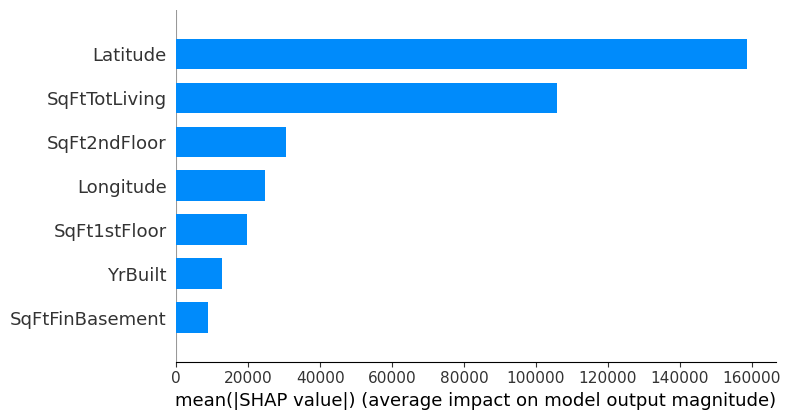

In [21]:
gbr = GradientBoostingRegressor()

#SHAP explainer
import shap

shap.initjs()

# Train a regression model (e.g., RandomForestRegressor)
gbr.fit(X_train_transformed_df, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(gbr, X_train_transformed_df)

# Calculate SHAP values
shap_values = explainer(X_test_transformed_df)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", feature_names=X.columns)

In [22]:
shap.plots.force(shap_values[100])